# Implement Online portfolio algorithms directly into the Gyn environment

In [5]:
from stable_baselines3 import PPO

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import CheckpointCallback

from stable_baselines3.common.policies import ActorCriticPolicy

from typing import Any, Dict, List, Optional, Tuple, Type, TypeVar, Union, Callable

from stable_baselines3.common.type_aliases import GymEnv

import pandas as pd


from gym import spaces

import torch as th
from torch import nn
import numpy as np

from stable_baselines3.common.torch_layers import (
    BaseFeaturesExtractor,
    CombinedExtractor,
    FlattenExtractor,
    MlpExtractor,
    NatureCNN,
    create_mlp,
)

from stable_baselines3.common.type_aliases import Schedule

class SCRPModel:
    def __init__(
            self, 
            env: Union[GymEnv, str],
            policy: Any, # Policy doesnt matter here
            device: str, # device doesnt matter here
            policy_kwargs: Optional[Dict[str, Any]] = None, # policy_kwargs doesnt matter here
            price_history: Optional[pd.DataFrame] = None
            ) -> None:
        
        # Super simple algorithm, we only need the environment

        assert env is not None 
        self.env = env

        # Pull out the actions space dimensions for the portfolio
        self.action_space_shape = self.env.action_space.shape
        self.portfolio_length = self.action_space_shape[0]
        
        self.price_history = pd.DataFrame()

        # If available, set additional price history
        if price_history is not None:
            self.price_history = price_history

        # Start with uniform portfolio weights
        self.current_weights = np.ones(self.portfolio_length-1) / (self.portfolio_length-1)  # target weights for each asset
        # Append 0 to the beginning, for an empty cash account
        self.current_weights = np.insert(self.current_weights, 0, 0)

    def train(self) -> None:
        # This model is derministic and doesnt learn anything, it only predicts
        raise NotImplementedError("Can't use 'train' on a benchmark model, use predict instead. These models are deterministic.")

    def learn(
        self
    ):
        # This model is derministic and doesnt learn anything, it only predicts
        raise NotImplementedError("Can't use 'learn' on a benchmark model, use predict instead. These models are deterministic.")

    def predict(
        self,
        observation: Union[np.ndarray, Dict[str, np.ndarray]],
        state: Optional[Tuple[np.ndarray, ...]] = None,
        episode_start: Optional[np.ndarray] = None,
        deterministic: bool = False, # This is always determininistic
    ) -> Tuple[np.ndarray, Optional[Tuple[np.ndarray, ...]]]:

        # This comes from the policies class in stable baselines.
        # Use this to validate the environment.
        if isinstance(observation, tuple) and len(observation) == 2 and isinstance(observation[1], dict):
            raise ValueError(
                "You have passed a tuple to the predict() function instead of a Numpy array or a Dict. "
                "You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) "
                "vs `obs = vec_env.reset()` (SB3 VecEnv). "
                "See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 "
                "and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api"
            )
        
        # Reshape the array to remove single dimensions 
        reshaped_array = observation.reshape(len(self.env._features), self.portfolio_length - 1) 

        # This assumes the close prices are in the environment.
        # This will break if close prices are not first in the environment
          
        prices = reshaped_array[0].tolist()

        new_row = pd.DataFrame([prices])

        # Add to the price history
        self.price_history = pd.concat([self.price_history, new_row], ignore_index=True)

        # Normalize the prices
        r = {}
        for name, s in self.price_history.items():
            init_val = s.loc[s.first_valid_index()]
            r[name] = s / init_val
        normalized_price_history = pd.DataFrame(r)

        if len(normalized_price_history) <= 1:
            action_weights = self.current_weights
            actions = action_weights.reshape(1, self.portfolio_length)
            return actions, None

        # Find the optimal portfolio over the window price history
        self.current_weights = np.array(optimize_log_returns(normalized_price_history))

        assert np.isclose(self.current_weights.sum(), 1), "The array does not sum up to one."

        # Use the last portfolio as the new action (keep it the same)
        action_weights = np.insert(self.current_weights, 0, 0)
        actions = action_weights.reshape(1, self.portfolio_length)

        return actions, None

import scipy.optimize as optimize
# Found this here:  
# https://github.com/Marigold/universal-portfolios/blob/master/universal/tools.py
def optimize_log_returns(
    prices
):
    assert prices.notnull().all().all()

    x_0 = np.ones(prices.shape[1]) / float(prices.shape[1])

    # Using price returns here.
    objective = lambda b: -np.sum(np.log(np.maximum(np.dot(prices - 1, b) + 1, 0.0001)))

    # We do not allow this portfolio to hold cash
    cons = ({"type": "eq", "fun": lambda b: 1 - sum(b)},)

    # problem optimization
    res = optimize.minimize(
        objective,
        x_0,
        bounds=[(0.0, 1.0)] * len(x_0),
        constraints=cons,
        method="slsqp"
    )

    if res.success:
        return res.x
    raise ValueError("Could not find an optimal value when optimizing over prices.")

MODELS = {
    "scrp": SCRPModel, 
}

# We tweak the ActorCriticPolicy to apply softmax normalization to the output actions
class CustomActorCriticPolicy(ActorCriticPolicy):
    def __init__(
        self,
        observation_space: spaces.Space,
        action_space: spaces.Space,
        lr_schedule: Schedule,
        net_arch: Optional[Union[List[int], Dict[str, List[int]]]] = None,
        activation_fn: Type[nn.Module] = nn.Tanh,
        ortho_init: bool = True,
        use_sde: bool = False,
        log_std_init: float = 0.0,
        full_std: bool = True,
        use_expln: bool = False,
        squash_output: bool = False,
        features_extractor_class: Type[BaseFeaturesExtractor] = FlattenExtractor,
        features_extractor_kwargs: Optional[Dict[str, Any]] = None,
        share_features_extractor: bool = True,
        normalize_images: bool = True,
        optimizer_class: Type[th.optim.Optimizer] = th.optim.Adam,
        optimizer_kwargs: Optional[Dict[str, Any]] = None,
        **kwargs,
    ):

        # Pass all initialization variables to the base class
        super().__init__(
            observation_space=observation_space,
            action_space=action_space,
            lr_schedule=lr_schedule,
            net_arch=net_arch,
            activation_fn=activation_fn,
            ortho_init=ortho_init,
            use_sde=use_sde,
            log_std_init=log_std_init,
            full_std=full_std,
            use_expln=use_expln,
            squash_output=squash_output,
            features_extractor_class=features_extractor_class,
            features_extractor_kwargs=features_extractor_kwargs,
            share_features_extractor=share_features_extractor,
            normalize_images=normalize_images,
            optimizer_class=optimizer_class,
            optimizer_kwargs=optimizer_kwargs,
            **kwargs
        )

        # Set up the softmax function
        self.softmax = nn.Sequential(nn.Softmax(dim=-1))

    def _build_mlp_extractor(self) -> None:
        """
        Create the policy and value networks.
        Part of the layers can be shared.
        """
        # Note: If net_arch is None and some features extractor is used,
        #       net_arch here is an empty list and mlp_extractor does not
        #       really contain any layers (acts like an identity module).
        self.mlp_extractor = MlpExtractor(
            self.features_dim,
            net_arch=self.net_arch,
            activation_fn=self.activation_fn,
            device=self.device,
        )

    def forward(self, obs: th.Tensor, deterministic: bool = False) -> Tuple[th.Tensor, th.Tensor, th.Tensor]:
        # Preprocess the observation if needed
        features = self.extract_features(obs)
        if self.share_features_extractor:
            latent_pi, latent_vf = self.mlp_extractor(features)
        else:
            pi_features, vf_features = features
            latent_pi = self.mlp_extractor.forward_actor(pi_features)
            latent_vf = self.mlp_extractor.forward_critic(vf_features)
        # Evaluate the values for the given observations
        values = self.value_net(latent_vf)
        distribution = self._get_action_dist_from_latent(latent_pi)
        actions = distribution.get_actions(deterministic=deterministic)
        log_prob = distribution.log_prob(actions)
        actions = actions.reshape((-1, *self.action_space.shape))  # type: ignore[misc]

        # APPLY SOFTMAX to the actions
        actions = self.softmax(actions)

        return actions, values, log_prob
    
    def predict(
        self,
        observation: Union[np.ndarray, Dict[str, np.ndarray]],
        state: Optional[Tuple[np.ndarray, ...]] = None,
        episode_start: Optional[np.ndarray] = None,
        deterministic: bool = False,
    ) -> Tuple[np.ndarray, Optional[Tuple[np.ndarray, ...]]]:
        """
        Get the policy action from an observation (and optional hidden state).
        Includes sugar-coating to handle different observations (e.g. normalizing images).

        :param observation: the input observation
        :param state: The last hidden states (can be None, used in recurrent policies)
        :param episode_start: The last masks (can be None, used in recurrent policies)
            this correspond to beginning of episodes,
            where the hidden states of the RNN must be reset.
        :param deterministic: Whether or not to return deterministic actions.
        :return: the model's action and the next hidden state
            (used in recurrent policies)
        """
        # Switch to eval mode (this affects batch norm / dropout)
        self.set_training_mode(False)

        # Check for common mistake that the user does not mix Gym/VecEnv API
        # Tuple obs are not supported by SB3, so we can safely do that check
        if isinstance(observation, tuple) and len(observation) == 2 and isinstance(observation[1], dict):
            raise ValueError(
                "You have passed a tuple to the predict() function instead of a Numpy array or a Dict. "
                "You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) "
                "vs `obs = vec_env.reset()` (SB3 VecEnv). "
                "See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 "
                "and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api"
            )

        obs_tensor, vectorized_env = self.obs_to_tensor(observation)

        with th.no_grad():
            actions = self._predict(obs_tensor, deterministic=deterministic)

            # APPLY SOFTMAX to the actions
            actions = self.softmax(actions)

        # Convert to numpy, and reshape to the original action shape
        actions = actions.cpu().numpy().reshape((-1, *self.action_space.shape))  # type: ignore[misc, assignment]

        if isinstance(self.action_space, spaces.Box):
            if self.squash_output:
                # Rescale to proper domain when using squashing
                actions = self.unscale_action(actions)  # type: ignore[assignment, arg-type]
            else:
                # Actions could be on arbitrary scale, so clip the actions to avoid
                # out of bound error (e.g. if sampling from a Gaussian distribution)
                actions = np.clip(actions, self.action_space.low, self.action_space.high)  # type: ignore[assignment, arg-type]

        # Remove batch dimension if needed
        if not vectorized_env:
            assert isinstance(actions, np.ndarray)
            actions = actions.squeeze(axis=0)

        return actions, state  # type: ignore[return-value]
    
    
# We default to this agent using our custom actor critic policy
class DRLStableAgent:
    """Implementation for DRL algorithms for portfolio optimization.

    Note:
        During testing, the agent is optimized through online learning.
        The parameters of the policy is updated repeatedly after a constant
        period of time. To disable it, set learning rate to 0.

    Attributes:
        env: Gym environment class.
    """

    def __init__(self, env):
        """Agent initialization.

        Args:
            env: Gym environment to be used in training.
        """
        self.env = env

    def get_model(
        self, model_name, device="cpu", model_kwargs=None, policy_kwargs=None
    ):
        """Setups DRL model.

        Args:
            model_name: Name of the model according to MODELS list.
            device: Device used to instantiate neural networks.
            model_kwargs: Arguments to be passed to model class.
            policy_kwargs: Arguments to be passed to policy class.

        Note:
            model_kwargs and policy_kwargs are dictionaries. The keys must be strings
            with the same names as the class arguments. Example for model_kwargs::

            { "lr": 0.01, "policy": EIIE }

        Returns:
            An instance of the model.
        """
        if model_name not in MODELS:
            raise NotImplementedError("The model requested was not implemented.")

        model = MODELS[model_name]
        model_kwargs = {} if model_kwargs is None else model_kwargs
        policy_kwargs = {} if policy_kwargs is None else policy_kwargs

        # add device settings
        model_kwargs["device"] = device
        #policy_kwargs["device"] = device

        # add policy_kwargs inside model_kwargs
        model_kwargs["policy_kwargs"] = policy_kwargs

        # Default to use the the custom policy which applies softmax normalization
        return model(env=self.env, policy=CustomActorCriticPolicy, **model_kwargs)

    @staticmethod
    def train_model(model, env, tb_log_name=None, episodes=1):
        """Trains portfolio optimization model.

        Args:
            model: Instance of the model.
            episoded: Number of episodes.

        Returns:
            An instance of the trained model.
        """
        max_steps = len(env._df['date'].unique())

        print("Max number of time steps in an episode: ", max_steps)

        checkpoint_callback = CheckpointCallback(
            save_freq=1000000,
            save_path="./results/",
            name_prefix="model_checkpoint",
            save_replay_buffer=True,
            save_vecnormalize=True,
        )

        model.learn(
            total_timesteps = max_steps * episodes,
            callback=checkpoint_callback,
            tb_log_name=tb_log_name,
            progress_bar=True
        )
        return model

    @staticmethod
    def DRL_prediction(model, env, deterministic=True, verbose=False):
        """make a prediction and get results"""
        test_env, test_obs = env.get_sb_env()
        
        test_env.reset()
        max_steps = len(env._df['date'].unique())

        validation_assets = None
        validation_dates = None

        for i in range(max_steps):
            action, _states = model.predict(test_obs, deterministic=deterministic)

            if(verbose):
                print("Step: ", str(i))
                print("Observations: ")
                print(test_obs)
                print("Actions: ")
                print(action)

            # Pull out the latest assets and dates
            validation_assets = env._asset_memory["final"]
            validation_dates = env._date_memory

            test_obs, rewards, dones, info = test_env.step(action)

            if dones[0]:
                print("hit end!")
                break
        
        return validation_assets, validation_dates

In [6]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER

# from finrl.agents.portfolio_optimization.architectures import EIIE

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

# HISTORY DATA FOR SCRP
HISTORY_START_DATE = '2010-01-01'

HISTORY_END_DATE = '2023-03-15'

TEST_START_DATE = '2023-03-15'
TEST_END_DATE = '2024-10-31'


from finrl.meta.preprocessor.yahoodownloader import YahooDownloader


TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]

# STOCKS = [
#     "AAPL",
#     "MSFT",
#     "V",
# ]

# No time window needed for PPO
# TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

history_df = YahooDownloader(start_date = HISTORY_START_DATE,
                     end_date = HISTORY_END_DATE,
                     ticker_list = TEST_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (19926, 8)


In [11]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER

# from finrl.agents.portfolio_optimization.architectures import EIIE

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader


TEST_TICKER = [
   "MSFT",
    "V",
    "AAPL",
    "BA",
    "INTC",
    "WMT",
]
# No time window needed for PPO
# TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

raw_df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = TEST_TICKER).fetch_data()


from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

# DONT USE NORMALIZED PRICES FOR SCRP
# portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(raw_df)


from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv

environment = PortfolioOptimizationEnv(
        raw_df,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close", "high", "low"],
        normalize_df=None
    )

SCRP_results = {
    "date": {},
    "training": {},
    "2021": {},
    "2022": {},
    "2023": {}
}

print(history_df)

print(raw_df)

history_df_environment = PortfolioOptimizationEnv(
        history_df,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close", "high", "low"],
        normalize_df=None
    )

# Pull out the historical price data for SCRP over the training period
agent_scrp = DRLStableAgent(env = history_df_environment)
history_scrp = agent_scrp.get_model("scrp")

_, _ = DRLStableAgent.DRL_prediction(history_scrp, history_df_environment)

print("Prices")
print(history_scrp.price_history)

# now make the predictions with the historical price data, but in the test period only
SCRP_model_kwargs = {
    "price_history": history_scrp.price_history
}

# Pull out the historical price data for SCRP
agent_scrp = DRLStableAgent(env = environment)
model_scrp = agent_scrp.get_model("scrp", model_kwargs=SCRP_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_scrp, environment)
SCRP_results["training"] = environment._terminal_asset_memory["final"]
SCRP_results["date"] = environment._terminal_date_memory

print(SCRP_results["date"])



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Shape of DataFrame:  (2466, 8)
             date        open        high         low       close     volume  \
0      2010-01-04    7.622500    7.660714    7.585000    6.447411  493729600   
1      2010-01-04   55.720001   56.389999   54.799999   43.777557    6186700   
2      2010-01-04   20.790001   21.030001   20.730000   13.519425   47800900   
3      2010-01-04   30.620001   31.100000   30.590000   23.300676   38409100   
4      2010-01-04   22.000000   22.192499   21.865000   19.785189   20180000   
...           ...         ...         ...         ...         ...        ...   
19921  2023-03-14  207.529999  213.559998  205.000000  207.279999    8245700   
19922  2023-03-14   27.350000   28.100000   27.250000   27.338528   47689800   
19923  2023-03-14  256.750000  261.070007  255.860001  257.221893   33620300   
19924  2023-03-14  218.000000  219.869995  216.039993  215.713348    7985600   
19925  2023-03-14   45.896667   46.090000   45.666668   44.903976   25542600   

        

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 1515855.0
Final accumulative portfolio value: 1.515855
Maximum DrawDown: -0.1660663952546415
Sharpe ratio: 1.2977685582841259
Total commission cost: 0.014790203887969255
hit end!
[Timestamp('2023-03-15 00:00:00'), Timestamp('2023-03-16 00:00:00'), Timestamp('2023-03-17 00:00:00'), Timestamp('2023-03-20 00:00:00'), Timestamp('2023-03-21 00:00:00'), Timestamp('2023-03-22 00:00:00'), Timestamp('2023-03-23 00:00:00'), Timestamp('2023-03-24 00:00:00'), Timestamp('2023-03-27 00:00:00'), Timestamp('2023-03-28 00:00:00'), Timestamp('2023-03-29 00:00:00'), Timestamp('2023-03-30 00:00:00'), Timestamp('2023-03-31 00:00:00'), Timestamp('2023-04-03 00:00:00'), Timestamp('2023-04-04 00:00:00'), Timestamp('2023-04-05 00:00:00'), Timestamp('2023-04-06 00:00:00'), Timestamp('2023-04-10 00:00:00'), Timestamp('2023-04-11 00:00:00'), Timestamp('2023-04-12 00:00:00'), Timestamp('2023-04-13 00:00:00'), Timestamp('2023-04-14 00:00:00'), Timestamp('2023-0

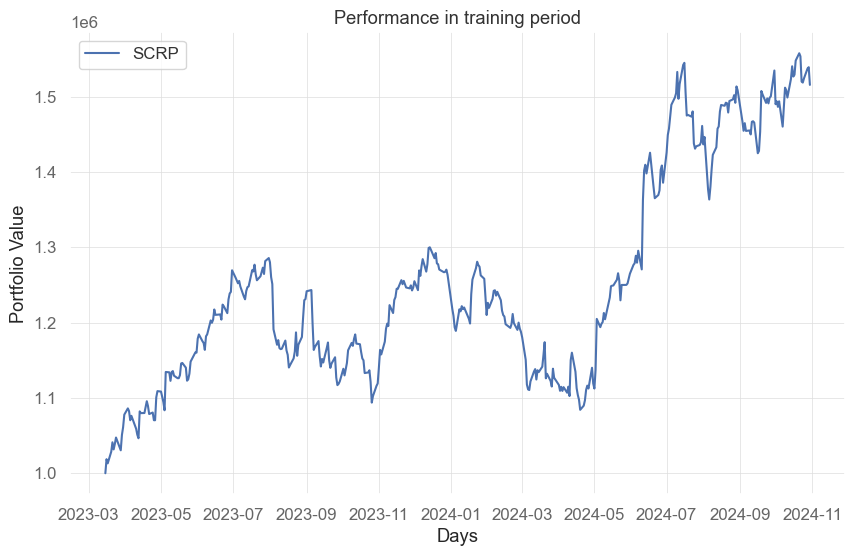

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(SCRP_results["date"], SCRP_results["training"], label="SCRP")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()